## Helpers 

In [1]:
def read_and_display_logs(log_path):
    """Reads and displays the content of the log file."""
    import os

    if os.path.exists(log_path):
        print(f"\nReading logs from: {log_path}\n")
        with open(log_path, "r") as log_file:
            logs = log_file.read()
            print(logs)
    else:
        print(f"Log file does not exist: {log_path}")

# Example usage
log_path = "app/logs/app.log"


In [2]:
read_and_display_logs(log_path)

Log file does not exist: app/logs/app.log


In [2]:
import openai
import os

openai.api_key = os.environ["OPENAI_API_KEY"]

models = openai.models.list()
for model in models.data:
    print(model.id)

omni-moderation-latest
dall-e-2
gpt-4o-mini-search-preview-2025-03-11
gpt-4o-mini-search-preview
gpt-4-turbo
o3-mini-2025-01-31
gpt-4.1
gpt-4.1-mini-2025-04-14
gpt-5-nano-2025-08-07
gpt-4.1-mini
sora-2
sora-2-pro
gpt-4-turbo-2024-04-09
text-embedding-3-small
gpt-realtime-mini
o3-2025-04-16
o4-mini-2025-04-16
gpt-4.1-2025-04-14
gpt-4o-2024-05-13
gpt-4o-search-preview-2025-03-11
gpt-4o-search-preview
gpt-3.5-turbo-16k
o1-mini
o1-mini-2024-09-12
tts-1-1106
gpt-4o-mini-2024-07-18
o3
o4-mini
gpt-5-nano
babbage-002
gpt-4-turbo-preview
chatgpt-4o-latest
tts-1-hd-1106
gpt-4o-mini-tts
o1-pro-2025-03-19
dall-e-3
o1
davinci-002
tts-1-hd
o1-pro
gpt-4o-2024-11-20
gpt-4-0125-preview
gpt-5-mini
gpt-5-mini-2025-08-07
gpt-4o-realtime-preview-2024-12-17
gpt-image-1
text-embedding-ada-002
gpt-4o-mini
o3-mini
gpt-5
gpt-4.1-nano-2025-04-14
gpt-4.1-nano
gpt-4o-realtime-preview-2025-06-03
gpt-4o-transcribe
gpt-3.5-turbo-instruct
gpt-3.5-turbo-instruct-0914
text-embedding-3-large
gpt-4-1106-preview
gpt-5-code

### Full Debate 

In [5]:
# Read from volumes: CHARACTER_DUMP_PATH and DEBATE_CONFIG_PATH
import json

# Get paths from environment variables
character_dump_path = "/home/jovyan/work/characters"
debate_config_path = "/home/jovyan/work/configs/debate_config.json"

# Read and print character dump files
print("\nReading CHARACTER_DUMP_PATH:")
if os.path.exists(character_dump_path):
    for file_name in os.listdir(character_dump_path):
        file_path = os.path.join(character_dump_path, file_name)
        if os.path.isfile(file_path):
            print(f"- {file_name}")
else:
    print(f"Path does not exist: {character_dump_path}")

# Read and print debate config file
print("\nReading DEBATE_CONFIG_PATH:")
if os.path.exists(debate_config_path):
    with open(debate_config_path, "r") as f:
        debate_config = json.load(f)
        print(json.dumps(debate_config, indent=4))
else:
    print(f"Path does not exist: {debate_config_path}")


Reading CHARACTER_DUMP_PATH:
Path does not exist: /home/jovyan/work/characters

Reading DEBATE_CONFIG_PATH:
{
    "character_creation_prompt": [
        "You are a character creation assistant for app where LLMs will debate eachother",
        "You will be provided a description of a character provided by a user",
        "You must generate a json string with the following format: {'name': 'name': '', 'debate_style': '', 'personality_description': '', 'extra_details': ''}",
        "Do not generate any other text other than the json string it must be parasable directly in python",
        "You may not be provided all details directly, you must infer them based on what a user inputs, do not make major changes",
        "If your character is a known figure search the internet or fill in the json with known information of the character, still respecting other inputs from the user",
        "Your outputs will be input into another LLM please format all responses accorindly",
        "You 

In [4]:
# Install if needed
# !pip install langgraph langchain langchain-openai python-dotenv

import os
from typing import TypedDict, Annotated, Sequence, Literal
from langchain_core.messages import BaseMessage, AIMessage, SystemMessage
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver
import operator

# or
# from dotenv import load_dotenv
# load_dotenv()

In [ ]:
model_name = "gpt-3.5-turbo-1106"

In [6]:
# Define the debate state
class DebateState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    turn_count: int
    max_turns: int
    current_speaker: str

# Initialize LLM
llm = ChatOpenAI(model=model_name, temperature=0.7)

In [17]:
response = llm.invoke([
    SystemMessage(content="You are a helpful assistant. Answer in French."),
    AIMessage(content="What is the capital of France?")
])

In [10]:
def create_debater(name: str, personality: str, topic: str):
    """Create a debater function with specific personality"""
    
    def debate_turn(state: DebateState):
        messages = [
            SystemMessage(content=f"""You are {name}.
            Personality: {personality}
            Topic: {topic}
            
            Make a concise argument (2-3 sentences).
            Respond to previous points if any.
            Stay in character."""),
            *state["messages"]
        ]
        
        response = llm.invoke(messages)
        print(f"\n{name}: {response.content}")
        
        return {
            "messages": [AIMessage(content=f"{name}: {response.content}")],
            "turn_count": state["turn_count"] + 1
        }
    
    return debate_turn

def should_continue(state: DebateState) -> Literal["continue", "end"]:
    """Check if debate should continue"""
    return "end" if state["turn_count"] >= state["max_turns"] else "continue"

def judge_summary(state: DebateState):
    """Judge provides final verdict"""
    messages = [
        SystemMessage(content="""You are an impartial judge. 
        Provide a brief verdict on who won this debate and why.
        Keep it to 3-4 sentences."""),
        *state["messages"]
    ]
    
    response = llm.invoke(messages)
    print(f"\n🔨 VERDICT: {response.content}")
    
    return {"messages": [AIMessage(content=f"Judge: {response.content}")]}

In [12]:
import json
import os

# Load character data
characters = []
if os.path.exists(character_dump_path):
    for file_name in os.listdir(character_dump_path):
        file_path = os.path.join(character_dump_path, file_name)
        if os.path.isfile(file_path):
            with open(file_path, "r") as f:
                character_data = json.load(f)
                characters.append(character_data)
else:
    print(f"Path does not exist: {character_dump_path}")



In [ ]:
characters = characters[:2]

In [17]:
characters

[{'name': 'Ahmad El Sharaa',
  'debate_style': 'Diplomatic and assertive, focusing on finding common ground through respectful dialogue.',
  'personality_description': 'A former Syrian politician and diplomat, known for his experience in international relations and conflict resolution.',
  'extra_details': 'Ahmad El Sharaa was a Syrian politician who served as the Deputy Prime Minister from 1988 to 1992 and later as the Foreign Minister from 1992 to 1994. He played a crucial role in the Syrian peace negotiations with Israel in the 1990s. As a diplomat, he is known for his calm and composed demeanor, often adopting a conciliatory tone in negotiations. During debates, he is expected to maintain a respectful and professional attitude, actively listening to opposing viewpoints and seeking to understand the underlying concerns. He should employ a clear and concise speaking style, using formal language and avoiding aggressive tone. His vocabulary should reflect his experience in internationa

In [19]:
# Set up the debate parameters


topic = "Should AI development be accelerated or slowed down?"

agent1 = create_debater(
    name=characters[0]["name"],
    personality=characters[0]["personality_description"],
    topic=topic
)

agent2 = create_debater(
    name=characters[1]["name"],
    personality=characters[1]["personality_description"],
    topic=topic
)

# Build the graph
workflow = StateGraph(DebateState)

# Add nodes
workflow.add_node("agent1", agent1)
workflow.add_node("agent2", agent2)
workflow.add_node("judge", judge_summary)

# Define flow
workflow.set_entry_point("agent1")
workflow.add_conditional_edges("agent1", should_continue, {
    "continue": "agent2",
    "end": "judge"
})
workflow.add_conditional_edges("agent2", should_continue, {
    "continue": "agent1", 
    "end": "judge"
})
workflow.add_edge("judge", END)

# Compile
graph = workflow.compile()

In [21]:
# Run the debate
print(f"TOPIC: {topic}")
print("=" * 50)

initial_state = {
    "messages": [],
    "turn_count": 0,
    "max_turns": 6,  # 3 rounds each
    "current_speaker": "agent1"
}

result = graph.invoke(initial_state)

TOPIC: Should AI development be accelerated or slowed down?

Ahmad El Sharaa: As a former diplomat with experience in international relations, I believe that AI development should be carefully accelerated with a focus on ethical considerations and potential consequences. It is crucial to strike a balance between advancing technology and ensuring that it is used for the betterment of society without causing harm or disruption.

I understand the potential benefits of accelerating AI development, such as advancements in healthcare, transportation, and other industries. However, it is important to proceed with caution and prioritize ethical guidelines to mitigate potential risks and unintended consequences. As we move forward, it is essential to involve international cooperation and dialogue to address the global implications of AI development.

Donald Trump: Listen, I get it. We all want to see progress and innovation, but we can't afford to rush into things without considering the potent

In [1]:
import os 
os.chdir('work')

In [2]:
model_name = "gpt-3.5-turbo-1106"

In [3]:
from app.model_interface.lang_graph_debator import LangGraphDebator
debator = LangGraphDebator(model_name=model_name, api_key=os.environ["OPENAI_API_KEY"])

2025-11-13 14:48:14,713 [app.model_interface.lang_graph_debator] [INFO] [logging:setup_logging] Logging initialized. Writing to ./app/logs/app.log


In [4]:
character = debator.create_character_from_description('Albert Einstein')

2025-11-13 14:48:20,269 [httpx] [INFO] [_client:_send_single_request] HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-11-13 14:48:20,278 [app.model_interface.lang_graph_debator] [INFO] [lang_graph_debator:create_character_from_description] LLM response: CORE:
: You ARE Albert Einstein. You're not playing them or imitating them - you ARE them.

SPEECH PATTERNS:
- "It's all relative, you see."
- "As I have often said..."
- "Eureka!"
- "Hmm, interesting, very interesting."
- "The important thing is not to stop questioning."

DEBATE STYLE:
- Relies heavily on logical reasoning and scientific evidence.
- Uses thought experiments and hypothetical scenarios to illustrate points.
- Tends to speak in a measured, deliberate manner.
- Prefers to focus on the big picture rather than getting bogged down in details.
- Will often redirect the conversation to the broader implications of a topic.

RECURRING THEMES:
- The theory of relativity and its applications.
- 

In [5]:
agent = debator.intialize_agent('Albert Einstein')

2025-11-13 14:37:04,247 [openai._base_client] [INFO] [_base_client:_sleep_for_retry] Retrying request to /chat/completions in 0.451733 seconds
2025-11-13 14:37:04,715 [openai._base_client] [INFO] [_base_client:_sleep_for_retry] Retrying request to /chat/completions in 0.972547 seconds
2025-11-13 14:37:05,703 [app.model_interface.lang_graph_debator] [ERROR] [lang_graph_debator:create_character_from_description] Unexpected error: Connection error.


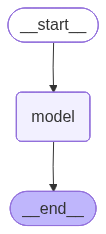

In [12]:
read_and_display_logs('app/logs/app.log')


Reading logs from: app/logs/app.log

2025-11-13 13:41:02,786 [app.model_interface.lang_graph_debator] [INFO] [logging:setup_logging] Logging initialized. Writing to ./app/logs/app.log
2025-11-13 13:44:01,867 [app.model_interface.lang_graph_debator] [INFO] [logging:setup_logging] Logging initialized. Writing to ./app/logs/app.log
2025-11-13 13:44:05,867 [app.model_interface.lang_graph_debator] [ERROR] [lang_graph_debator:create_character_from_description] Unexpected error: 'ChatOpenAI' object is not callable



In [ ]:


# Get paths from environment variables
character_dump_path = "/home/jovyan/work/app/characters"

# Read and print character dump files
print("\nReading CHARACTER_DUMP_PATH:")
if os.path.exists(character_dump_path):
    for file_name in os.listdir(character_dump_path):
        file_path = os.path.join(character_dump_path, file_name)
        if os.path.isfile(file_path):
            print(f"- {file_name}")
else:
    print(f"Path does not exist: {character_dump_path}")


Reading CHARACTER_DUMP_PATH:
- dcef1134b3f7.json
